# Lecture 9: From dense to sparse linear algebra

## Recap of the previous lecture
- Algorithms for the symmetric eigenvalue problems (QR-algorithm, Divide-and-Conquer, bisection)
- SVD and its applications (collaborative filtering, integral equations, latent semantic indexing)


## Interesting fact 1

Before $$A_k = Q_k R_k, \quad A_{k+1} = R_k Q_k,$$

there was $LU-UL$ algorithm by [Heinz Rutishauser](https://en.wikipedia.org/wiki/Heinz_Rutishauser)

$$A_k = L_k U_k, \quad A_{k+1} = U_k L_k.$$

This generates a sequence of similar matrices, but is less stable than QR algorithm.

Int. fact: Heinz Rutishauser has proposed the **for** keyword in programming language.

## Interesting fact 2

Recent paper [Strassen algorithm reloaded](http://delivery.acm.org/10.1145/3020000/3014983/a59-huang.pdf?ip=89.106.174.124&id=3014983&acc=OPEN&key=4D4702B0C3E38B35%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35%2E6D218144511F3437&CFID=850797828&CFTOKEN=25065737&__acm__=1479192384_96a207c8760b13d6521f71b8bbc370f0)
claim to **break conventional wisdom** that Strassen algorithm is not very practical.

- Conventional wisdom: it is only
 practical for very large matrices. The proposed implementation is practical
 for small matrices. 
- Conventional wisdom: the matrices being
 multiplied should be relatively square. The proposed implementation is
 practical for rank-k updates, where k is relatively small (a shape
 of importance for libraries like LAPACK). 
- Conventional wisdom:
  it inherently requires substantial workspace. The proposed implementation
  requires no workspace beyond buffers already incorporated
  into conventional high-performance DGEMM implementations.
- Conventional wisdom: a Strassen DGEMM interface must pass
 in workspace. The proposed implementation requires no such workspace
 and can be plug-compatible with the standard DGEMM interface.
- Conventional wisdom: it is hard to demonstrate speedup
 on multi-core architectures. The proposed implementation demonstrates
 speedup over conventional DGEMM even on an IntelR Xeon
 PhiTM coprocessor utilizing 240 threads. It is shown how a distributed
 memory matrix-matrix multiplication also benefits from
 these advances.

## Sparse matrices 

For dense linear algebra problems, we are limited by the memory to store the full matrix, it is $N^2$ parameters.

The class of **sparse** matrices where most of the elements are zero, allows us **at least** to store such matrices.

The question if we can:

- Solve linear systems
- Solve eigenvalue problems

with sparse matrices. 

## Today lecture

Today we will talk about **sparse matrices**, where they arise, how we store them, how we operate with them.


- Formats: list of lists and compressed sparse row format, relation to graphs
- Fast matrix-by-vector product
- Fast direct solvers for Gaussian elimination


## Applications of sparse matrices

Sparse matrices arise:

- In Partial Differential Equations (PDE), mathematical modelling
- In graphs mining (social networks)
- In recommender systems
- Wherever relations between objects are "sparse".

## Sparse matrices are ubiquitous in PDE
Consider the simplest partial differential equation (PDE), called **Laplace equation**:  
$$
   \Delta T = \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = f(x,y), \quad x,y\in \Omega\equiv[0,1]^2,
$$
$$
    T_{\partial\Omega} = 0.
$$

## Discretization
$$\frac{\partial^2 T}{\partial x^2} \approx \frac{T(x+h) + T(x-h) - 2T(x)}{h^2} + \mathcal{O}(h^2),$$
same for $\frac{\partial^2 T}{\partial y^2},$
and we get a linear system.  
    First, let us consider **one-dimensional case**:

After the discretization of the one-dimensional Laplace equation with Dirichlet boundary conditions we have
$$\frac{u_{i+1} + u_{i-1} - 2u_i}{h^2} = f_i,\quad i=1,\dots,N-1$$
$$ u_{0} = u_N = 0$$
or in the matrix form

$$
   A u = f,
$$
                   and ($n = 5$ illustration)
\begin{equation}
A=-\frac{1}{h^2}\begin{bmatrix}
   2& -1 & 0 & 0 & 0\\
   -1 & 2 & -1 & 0 &0 \\
   0 & -1 & 2& -1 & 0 \\
   0 & 0 & -1 & 2  &-1\\
   0 & 0 & 0 & -1 & 2
   \end{bmatrix}
   \end{equation}

The matrix is **triadiagonal** and **sparse**  
(and also **Toeplitz**: all elements on the diagonal are the same)

## Block structure in 2D
In two dimensions, we get equation of the form  
$$-\frac{4u_{ij} -u_{(i-1)j} - u_{(i+1)j} - u_{i(j-1)}-u_{i(j+1)}}{h^2} = f_{ij},$$

or in the **Kronecker product form**  

$$\Delta_{2D} = \Delta_{1D} \otimes I + I \otimes \Delta_{1D},$$

where $\Delta_{1D}$ is a 1D Laplacian, and $\otimes$ is a **Kronecker product** of matrices. 

For matrices $A\in\mathbb{R}^{n\times m}$ and $B\in\mathbb{R}^{l\times k}$ its Kronecker product is defined as a block matrix of the form 
$$
   A\otimes B = \begin{bmatrix}a_{11}B & \dots & a_{1m}B \\ \vdots & \ddots & \vdots \\ a_{n1}B & \dots & a_{nm}B\end{bmatrix}\in\mathbb{R}^{nl\times mk}.
$$

In the block matrix form the 2D-Laplace matrix can be written in the following form:  

$$
   A = -\frac{1}{h^2}\begin{bmatrix}
   \Delta_1 + 2I & -I & 0 & 0 & 0\\
   -I & \Delta_1 + 2I  & -I & 0 &0 \\
   0 & -I & \Delta_1 + 2I & -I & 0 \\
   0 & 0 & -I & \Delta_1 + 2I   &-I\\
   0 & 0 & 0 & -I & \Delta_1 + 2I 
   \end{bmatrix}
$$

## Short list of Kronecker product properties

- It is bilinear
- $(A\otimes B) (C\otimes D) = AC \otimes BD$
- Let $\mathrm{vec}(X)$ be vectorization of matrix $X$ columnwise. Then 
$\mathrm{vec}(AXB) = (B^T \otimes A) \mathrm{vec}(X).$

## Sparse matrix.

We can create this matrix using **scipy.sparse** package (actually this is **not the best** sparse matrix package)

We can go to really large sizes (at least, to store this matrix in the memory).

Please note the following functions
- Create sparse matrices with given diagonals ```spdiags```
- Kronecker product of sparse matrices ```kron```
- There is also overloaded arithmectics for sparse matrices

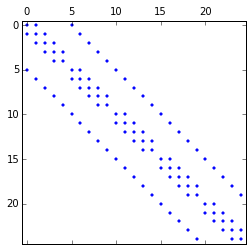

In [12]:
import numpy as np
import scipy as sp
import scipy.sparse
from scipy.sparse import csc_matrix, csr_matrix
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.sparse.linalg
%matplotlib inline
n = 5
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csc_matrix(A)
plt.spy(A, aspect='equal', marker='.', markersize=5)

## Sparsity pattern 

The ```spy``` command plots the sparsity pattern of the matrix: the $(i, j)$ pixel is drawn, if the corresponding matrix element is non-zero.

Sparsity pattern is really important for the understanding the complexity of the sparse linear algebra algorithms.  

Often, only the sparsity pattern is needed for the analysis of "how complex" the matrix is.

## Sparse matrix: definition

The definition of "sparse matrix" is that the number of **non-zero elements** is much less than the total number of <br>
elements, so you can do the basic linear algebra operations (like solving linear systems at the first place) can be done faster, <br>
than if working for with the full matrix.

The **scipy.sparse** package has tools for solving sparse linear systems:

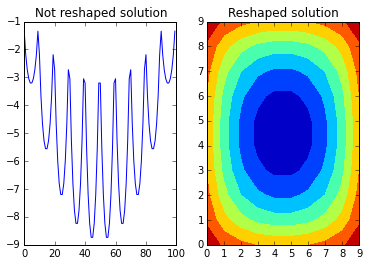

In [13]:
n = 10
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csr_matrix(A)
rhs = np.ones(n * n)
sol = sp.sparse.linalg.spsolve(A, rhs)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(sol)
ax1.set_title('Not reshaped solution')
ax2.contourf(sol.reshape((n, n), order='f'))
ax2.set_title('Reshaped solution')

## What we need to find out to see how it actually works

**Question 1:** How to store the sparse matrix in memory?

**Question 2:** How to multiply sparse matrix by vector fast?

**Question 3:** How to solve linear systems with sparse matrices fast?



## Sparse matrix storage

There are many storage formats, important ones:

- COO (Coordinate format)
- LIL (Lists of lists)
- CSR (compressed sparse row)
- CSC (compressed sparse column)
- Block variants

In ```scipy``` there are constructors for each of these formats, e.g. ```scipy.sparse.lil_matrix(A)```.

## Coordinate format (COO)

The simplest format is to use **coordinate format** to represent the sparse matrix as positions and values of non-zero elements.

```python
i, j, val
```

where ```i, j``` are integer array of indices, ```val``` is the real array of matrix elements. <br>
So we need to store $3\cdot$ **nnz** elements, where **nnz** denotes number of nonzeroes in the matrix.

**Q:** What is good and what is bad in this format?

## Main disadvantages

- It is not optimal in storage (why?)
- It is not optimal for matrix-by-vector product (why?)
- It is not optimal for removing elements as you must make **nnz** operations to find one element (this is good in LIL format)

First $2$ are solved by **compressed sparse row** (CSR) format.

## Compressed sparse row (CSR)

In the CSR format a matrix is stored as 3 different arrays: 
```python
ia, ja, sa
```
where:

- **ia** (row start) is an integer array of length $n+1$ 
- **ja** (column indices) is an integer array of length **nnz** 
-  **sa** (values) is an real-value array of length **nnz**

<img src="https://www.karlrupp.net/wp-content/uploads/2016/02/csr_storage_sparse_marix.png" width=60% />

So, we got $2\cdot{\bf nnz} + n+1$ elements.

## CSR helps for matrix-by-vector product as well
```python
   for i in range(n):
       for k in range(ia[i]:ia[i+1]):
           y[i] += sa[k] * x[ja[k]]
```

Let us do a short timing test

In [14]:
import numpy as np
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse import csc_matrix, csr_matrix, coo_matrix
import matplotlib.pyplot as plt
%matplotlib inline
n = 400
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csr_matrix(A)
rhs = np.ones(n * n)
B = coo_matrix(A)
%timeit A.dot(rhs)
%timeit B.dot(rhs)

1000 loops, best of 3: 926 µs per loop
1000 loops, best of 3: 1.59 ms per loop


As you see, **CSR** is faster, and for more **unstructured patterns** the gain will be larger.

## Sparse matrices and efficiency
Sparse matrices give complexity reduction.  
But they are **not very good** for parallel/GPU implementation.  

And they do not give maximal efficiency due to **random data access**.  
Typically, peak efficiency of $10\%-15\%$ is considered good.  

## Recall how we measure efficiency of linear algebra operations

The standard way to measure the efficiency of linear algebra operations on a particular computing architecture is to <br>
use **flops** (number of floating point operations per second)

The peak performance is determined as 

 **frequency** $\times$ **number of cores** $\times$ **pipeline size** $\times$ 2.

We can measure peak efficiency of an ordinary matrix-by-vector product.

In [15]:
import numpy as np
import time
n = 4000
a = np.random.randn(n, n)
v = np.random.randn(n)
t = time.time()
np.dot(a, v)
t = time.time() - t
print('Time: {0: 3.1e}, Efficiency: {1: 3.1e} Gflops'.\
      format(t,  ((2 * n ** 2)/t) / 10 ** 9))

Time:  1.4e-02, Efficiency:  2.3e+00 Gflops


In [16]:
n = 4000
ex = np.ones(n);
a = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.random.randn(n)
t = time.time()
a.dot(rhs)
t = time.time() - t
print('Time: {0: 3.1e}, Efficiency: {1: 3.1e} Gflops'.\
      format(t,  (3 * n) / t / 10 ** 9))

Time:  2.0e-04, Efficiency:  6.1e-02 Gflops


## How to make things more efficient

Sparse matrix computations dominate linear algebra computations nowadays.<br>
They allow us to work with much larger matrices, but they utilize only $10\%-15\%$ percent of the peak computer performance. <br>
It means, that our computer architecture **is not well suited** for standard sparse matrix algorithms.

There are many possible solutions of the problem, for example:

1. Use block sparse format
2. Reorder equations to make them more "block"
3. Instead of vectors, use "block vectors"

In [17]:
n = 1000000
k = 1
ex = np.ones(n);
a = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.random.randn(n, k)
t = time.time()
a.dot(rhs)
t = time.time() - t
print('Time: {0: 3.1e}, Efficiency: {1: 3.1e} Gflops'.\
      format(t,  (3 * n * k) / t / 10 ** 9))

Time:  6.9e-03, Efficiency:  4.3e-01 Gflops


## Florida sparse matrix collection

There are many other types of matrices besides tridiagonal/block tridiagonal

[Florida sparse matrix collection](http://www.cise.ufl.edu/research/sparse/matrices/) which contains all sorts of matrices for different applications.

It also allows for finding test matrices as well! 

We can have a look.

In [18]:
from IPython.display import HTML
HTML('<iframe src=http://yifanhu.net/GALLERY/GRAPHS/search.html width=700 height=450></iframe>')

## Visualization of sparse matrices and graphs

Sparse matrices and fast algorithms (especially for linear systems) have deep connection with graph theory.

First of all, sparse matrix can be treated as an **adjacency matrix** of a certain graph:

The vertices $(i, j)$ are connected, if the corresponding matrix element is non-zero.

If the matrix is symmetric the graph can be undirected, otherwise it is directed.

## Graph structure is important for LU decomposition

Why sparse linear systems can be solved faster, what is the technique? 

In the LU-factorization of the matrix $A$ the factors $L$ and $U$ can be also sparse:

$$A = L U$$

And solving linear systems with **sparse** triangular matrices is very easy.  

<font color='red'> Note that the inverse matrix is not sparse! </font>


In [19]:
#Indeed, it is not sparse
n = 7
ex = np.ones(n);
a = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
a = a.todense()
b = np.array(np.linalg.inv(a))
print a
print b

[[-2.  1.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  1. -2.]]
[[-0.875 -0.75  -0.625 -0.5   -0.375 -0.25  -0.125]
 [-0.75  -1.5   -1.25  -1.    -0.75  -0.5   -0.25 ]
 [-0.625 -1.25  -1.875 -1.5   -1.125 -0.75  -0.375]
 [-0.5   -1.    -1.5   -2.    -1.5   -1.    -0.5  ]
 [-0.375 -0.75  -1.125 -1.5   -1.875 -1.25  -0.625]
 [-0.25  -0.5   -0.75  -1.    -1.25  -1.5   -0.75 ]
 [-0.125 -0.25  -0.375 -0.5   -0.625 -0.75  -0.875]]


## And the factors...

$L$ and $U$ are typically sparse. In the tridiagonal case they are even bidiagonal!

In [25]:
from scipy.sparse.linalg import splu
T = splu(a, permc_spec="NATURAL")
print T.L.todense()

[[ 1.          0.          0.          0.          0.          0.          0.        ]
 [-0.5         1.          0.          0.          0.          0.          0.        ]
 [ 0.         -0.66666667  1.          0.          0.          0.          0.        ]
 [ 0.          0.         -0.75        1.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.8         1.          0.          0.        ]
 [ 0.          0.          0.          0.         -0.83333333  1.          0.        ]
 [ 0.          0.          0.          0.          0.         -0.85714286
   1.        ]]


Interesting to note that ```splu``` without ```permc_spec``` will produce permutations which will not yield the bidiagonal factor:

In [21]:
from scipy.sparse.linalg import splu
T = splu(a)
print T.L.todense()
print T.perm_c

[[ 1.          0.          0.          0.          0.          0.          0.        ]
 [-0.5         1.          0.          0.          0.          0.          0.        ]
 [ 0.         -0.66666667  1.          0.          0.          0.          0.        ]
 [ 0.          0.         -0.75        1.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.        ]
 [ 0.          0.          0.         -0.8        -0.5         1.          0.        ]
 [ 0.          0.          0.          0.         -0.5        -0.71428571
   1.        ]]
[0 1 2 3 5 4 6]


## 2D-case
In a 2D case everything is much worse:

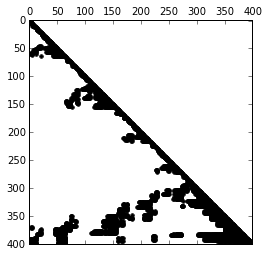

In [27]:
n = 20
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csc_matrix(A)
T = scipy.sparse.linalg.spilu(A)
plt.spy(T.L, marker='.', color='k', markersize=8)

For correct permutation in 2D case the number of nonzeros in  $L$ factor grows as $\mathcal{O}(N \log N)$. But  complexity is $\mathcal{O}(N^{3/2})$.

## Sparse matrices and graph ordering
The number of nonzeros in LU decomposition has a deep connection to the graph theory.

(I.e., there is an edge between $(i, j)$ if $a_{ij} \ne 0$.

``networkx package`` can be used to visualize graphs, given only the adjacency matrix. 

It may even recover to some extend the graph structure.

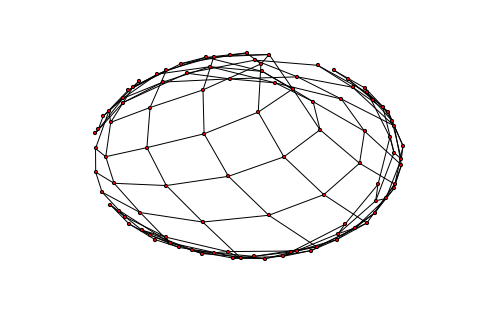

In [26]:
import networkx as nx
n = 10
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csc_matrix(A)
G = nx.Graph(A)
nx.draw(G, pos=nx.spring_layout(G), node_size=10)

## Fill-in

The fill-in of a matrix are those entries which change from an initial zero to a nonzero value during the execution of an algorithm.

The fill-in is different for different permutations. So, before factorization we need to find reordering which produces the smallest fill-in.

**Example**
$$A = 
    \begin{bmatrix} 
    * & * & * & * & *\\
    * & * & 0 & 0 & 0 \\
    * & 0  & * & 0 & 0 \\
    * & 0 & 0& * & 0 \\
    * & 0 & 0& 0 & *
    \end{bmatrix}
$$
If we elimate elements from the top to the bottom, then we will obtain dense matrix.
However, we could maintain sparsity if elimination was done from the bottom to the top.

## Fill-in minimization

Reordering the rows and the columns of the sparse matrix in order to reduce the number of nonzeros in $L$ and $U$ factors is called **fill-in** minimization. <br> 

Examples of algorithms for fill-in minimization:

- **Minimum degree ordering** - order by the degree of the vertex
- **Cuthill–McKee algorithm** (and reverse Cuthill-McKee) - reorder to minimize the bandwidth (does not exploit graph representation).
- **Nested dissection**: split the graph into two with minimal number of vertices on the separator (set of vertices removed after we separate the graph into two distinct connected graphs). <br> Complexity of the algorithm depends on the size of the graph separator. For 1D Laplacian separator contains only 1 vertex, in 2D - $\sqrt{N}$ vertices.

## Take home message
- CSR format for storage
- Sparse matrices & graphs ordering
- Ordering is important for LU fill-in: more details on Thursday.

# Questions?

In [24]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()